# Train a regression network to predict the blur kernel radius






# Project Documentation

In [1]:

from pathlib import Path
import os


project_base = "/media/SSD/superres/"
results_folder = "Results"
data_folder = "video_data"
model_folder = "checkpoint"

model_name_base = "BLUR1"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train blur kernel predictor v1.ipynb


In [4]:
nb_path = Path(NOTEBOOK_FULL_PATH)
print(nb_path)

# Make result folder if it does not exist
result_path = Path(project_base, results_folder , nb_path.stem )
print(result_path)
os.makedirs(result_path, exist_ok=True)

/SSD_link/superres/Superresolution train blur kernel predictor v1.ipynb
/media/SSD/superres/Results/Superresolution train blur kernel predictor v1


In [5]:
model_out_path=Path(project_base)/model_folder
print(model_out_path)
os.makedirs(model_out_path, exist_ok=True)

/media/SSD/superres/checkpoint


In [6]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [7]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale,ToPILImage

import random

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [8]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers

torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [9]:
#import fnmatch

In [10]:
from superres_utils import make_framelist, load_frame, RescaleCrop, Multifuz, DatasetFromVideoFolder
from superres_utils import show_batch
from superres_utils import pil_disk_blur, display_PSNR, test_results, superres_mp4

In [11]:
# get a list of all the data
instances = make_framelist("/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR",1)

(731, 491) (720, 480)


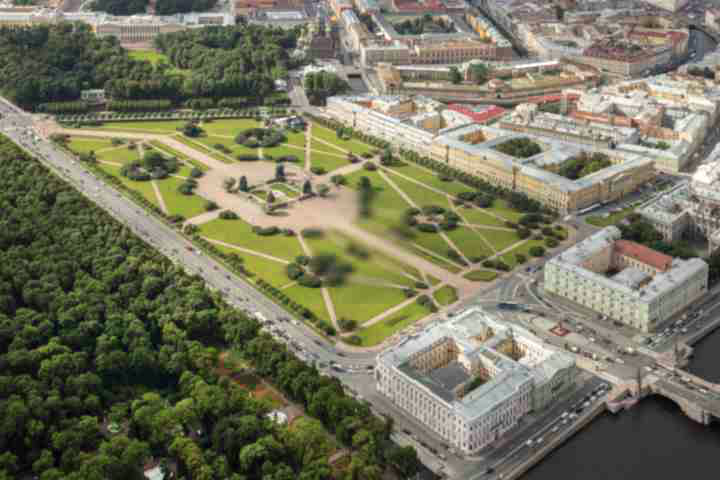

In [12]:
#test the Multifuz transform
im=load_frame(instances[10])
#im = Grayscale(num_output_channels=1)(im)
im = RescaleCrop(crop_size=(480,720),kernel_width=10)(im)
im_res = Multifuz(crop_size = (480,720),
                  center=(360,240),
                  kernel_a=2, 
                  kernel_b=10,
                  quality=np.int16(22), 
                  slope=.1,
                 radius=50,
                 scale=1)(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [13]:
def input_transform():        
    return Compose([        
        Grayscale(num_output_channels=1),
        ToTensor(),
    ])



def target_transform(crop_size):
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])


In [14]:
train_dir = "/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR"
#train_dir = "/home/filip/SSD_link/superres/video_data/train_data"
frame_sample_size =10
batch_size = 32 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
#crop_size = (128,128)
kernel_range=(0,16)
quality_range=(30,99) 
slope_range=(0.001, 0.1)
radius_range=(0,0)  # make all one fuzziness
scale_range=(1/2,2)
Flip_hor=True
Rand_bright_contrast=True

In [15]:
train_set = DatasetFromVideoFolder(train_dir,crop_size,frame_sample_size,
                                   input_transform=input_transform(),
                                   target_transform=target_transform(crop_size),
                                   Flip_hor=Flip_hor,
                                   Rand_bright_contrast=Rand_bright_contrast,
                                   kernel_range=kernel_range,
                                   quality_range=quality_range,
                                   slope_range=slope_range,
                                   radius_range=radius_range,
                                   scale_range=scale_range,
                                   max_kernel=10
                            )
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

In [16]:
valid_dir = "/home/filip/SSD_link/superres/DIV2K/DIV2K_valid_HR"
#frame_sample_size =10
#batch_size = 4 # Make 4 For FP16, 480x720 size images
#crop_size = (480,720)

kernel_range=(0,16)
quality_range=(30,99) 
slope_range=(0.001, 0.1)
radius_range=(0,0)  # make all one fuzziness
scale_range=(1/2,2)
Flip_hor=False
Rand_bright_contrast=False
match_exp = "*.*"

In [17]:
valid_set = DatasetFromVideoFolder(valid_dir,crop_size,frame_sample_size,
                                   input_transform=input_transform(),
                                   target_transform=target_transform(crop_size),
                                   Flip_hor=Flip_hor,
                                   Rand_bright_contrast=Rand_bright_contrast,
                                   kernel_range=kernel_range,
                                   quality_range=quality_range,
                                   slope_range=slope_range,
                                   radius_range=radius_range,
                                   scale_range=scale_range,
                                   max_kernel=10,
                                   match_exp=match_exp,
                            )
valid_data_loader = DataLoader(dataset=valid_set, num_workers=0, batch_size=batch_size, shuffle=False)

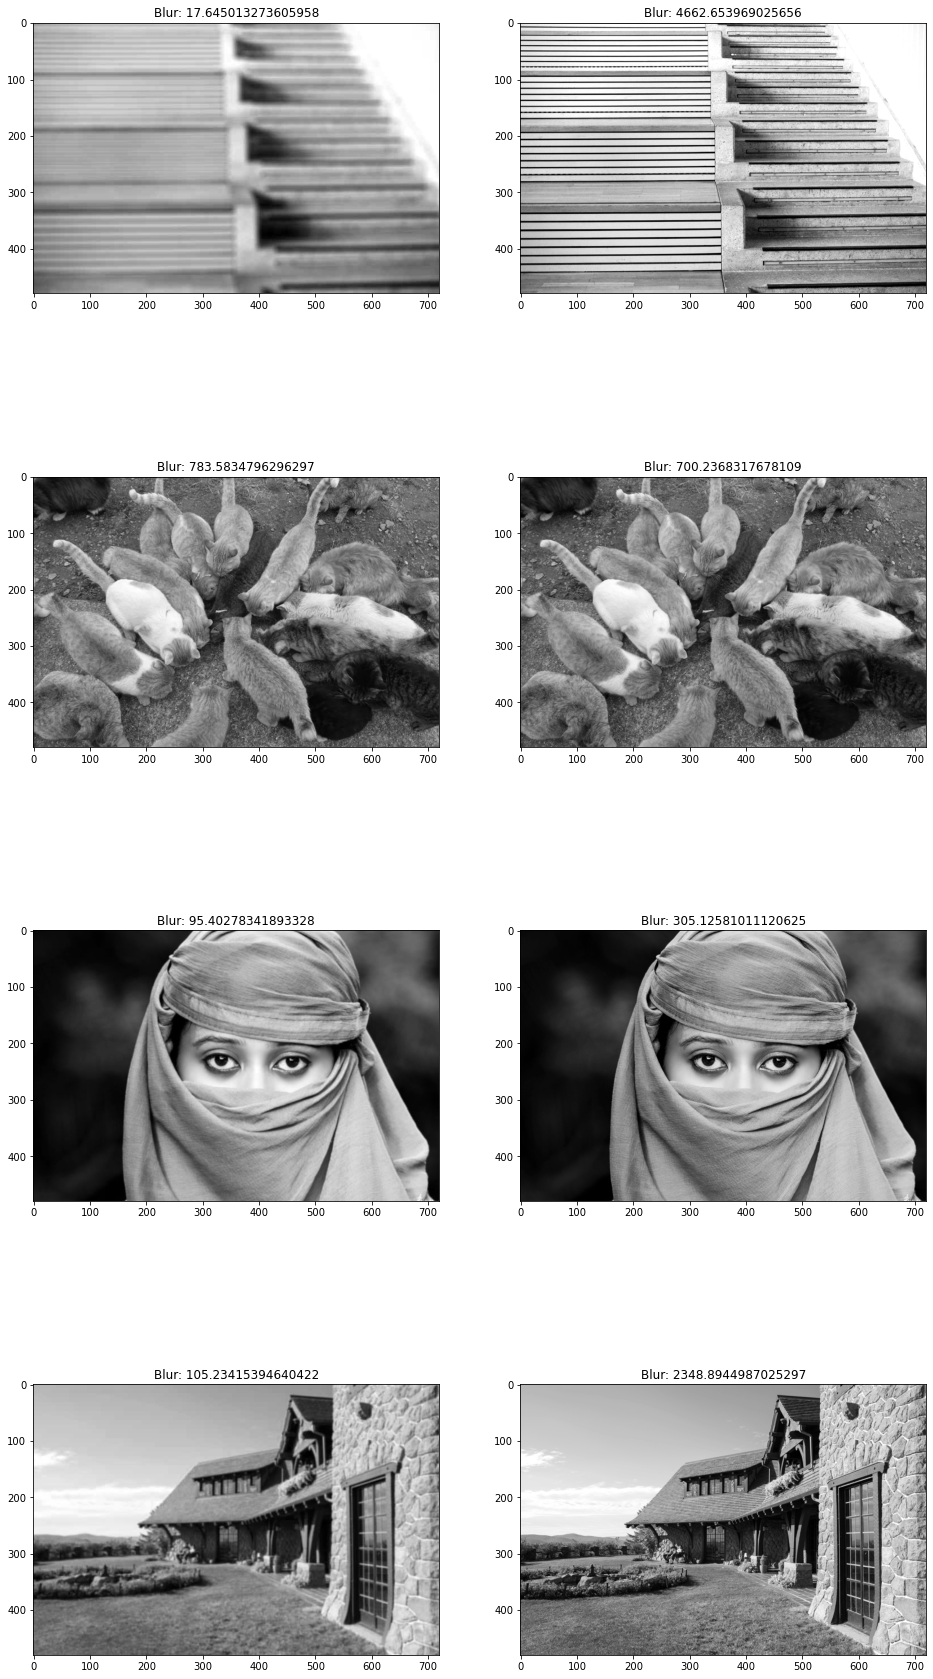

In [18]:
show_batch(training_data_loader,size =8)

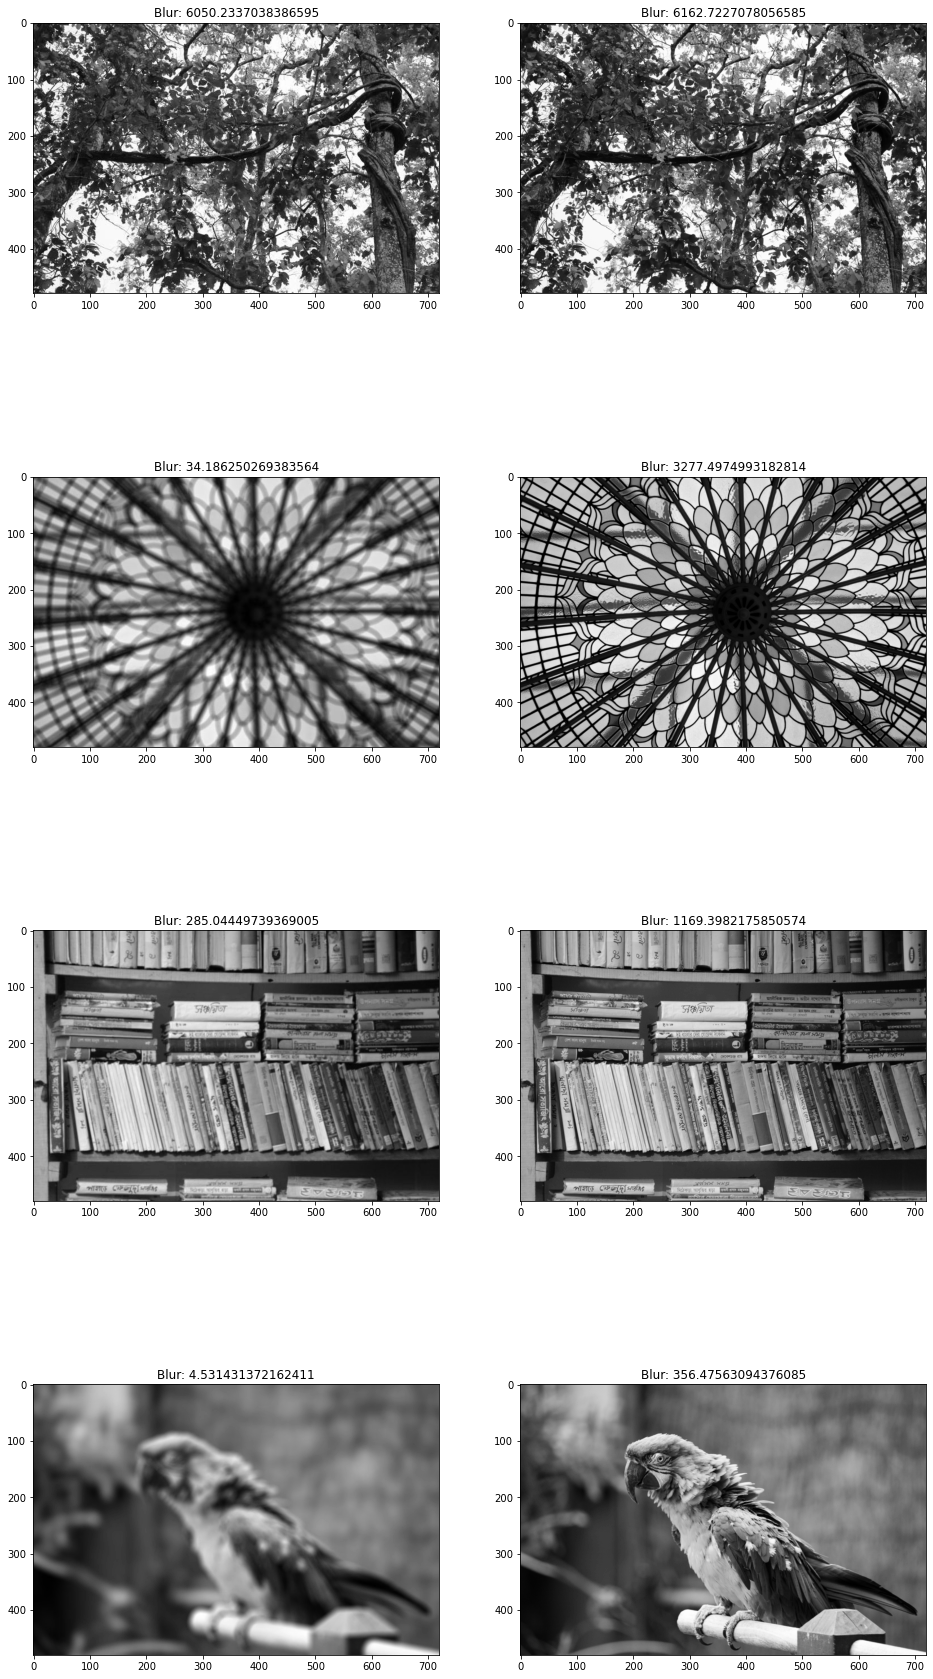

In [19]:
show_batch(valid_data_loader,size =8)

# NEW CNN for blur prediction

In [20]:
import torch.nn as nn

class BLURNet1(nn.Module):
    def __init__(self, c1, c2, c3):
        super(BLURNet1, self).__init__()   
        
        self.p1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels=c1, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=c1, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU()
        )
        
        
        self.convf = nn.Conv2d(in_channels=c1, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True)
        
        self.features = nn.Sequential(
            
            nn.Conv2d(c1, c1, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(c1, c1, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.regression = nn.Sequential(
            nn.Dropout(),
            nn.Linear(c1 * 6 * 6, c3),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(c3, c3),
            nn.ReLU(inplace=True),
            nn.Linear(c3, 1),
        )

              
        
        
    def forward(self, x):    
        
        x = self.p1(x)       
        k = self.features(x)
        k = self.avgpool(k)
        k = torch.flatten(k, 1)
        k = self.regression(k)
        
        
        return k

## Shufflenet v2

In [38]:
model2 = torch.hub.load('pytorch/vision:v0.6.0', 'shufflenet_v2_x0_5', pretrained=True)
model2

Using cache found in /home/filip/.cache/torch/hub/pytorch_vision_v0.6.0
Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /home/filip/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth


ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

In [39]:
model2.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [40]:
model2.fc = nn.Linear(1024, 1, bias=True)

# build the model

In [21]:
#model = NEWNet2(c1=64,c2=128)
model = BLURNet1(c1=16,c2=64, c3=256)  ##c2 doesn't have any effect
model.cuda()

BLURNet1(
  (p1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (convf): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (regression): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=576, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_fe

In [22]:

criterion = nn.MSELoss(reduction = 'mean')

In [23]:
init_lr = .001
lr_step = 3
gradient_clip = 0.4
epochs = 18
max_kernel_scale = 17
loops = 8

In [24]:

#optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)



In [25]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [26]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [27]:
def save_checkpoint(experiment, model, epoch, valid_error):

    model_out_str = str(model_out_path/(model_name_base+"_epoch_{}.pth")).format(epoch)
    
    state = {"experiment": experiment, "epoch": epoch ,"model": model, "valid_error": valid_error}

    torch.save(state, model_out_str)

    print("Checkpoint saved to {}".format(model_out_str))

In [28]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
#import kornia


In [29]:
from torch.optim.swa_utils import AveragedModel
swa_model = torch.optim.swa_utils.AveragedModel(model)

In [30]:
def trainfp16(training_data_loader, optimizer, scheduler, model,  epoch,scaler, loops):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    
    cum_loss = 0
    
    ct=0

    pbar = tqdm(total=loops*len(training_data_loader))
    for loopcount in range(loops):
        for iteration, batch in enumerate(training_data_loader, 1):
            inpt, target, camera_specs = batch[0], batch[1], batch[2]
            # we don't use the target for this model

            

            inpt = inpt.cuda()
            
            k_target = (camera_specs["kernel_a"].float()).cuda()

            optimizer.zero_grad()

            # Runs the forward pass with autocasting.
            with autocast():
                k = model(inpt)
                loss = criterion(k[:,0],k_target )
                


            
            scaler.scale(loss).backward()
            #loss.backward() 

            # Unscales the gradients of optimizer's assigned params in-place
            #scaler.unscale_(optimizer)

            #nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 

            #optimizer.step()
            scaler.step(optimizer)

            if epoch>1:
                swa_model.update_parameters(model)

            # Updates the scale for next iteration.
            scaler.update()

            #scheduler.step()

            cum_loss = cum_loss + loss.data
            ct = ct +1 



            pbar.update(1)
    pbar.close()    
   
    print("Epoch kernel est loss(RMSE):", (cum_loss/ct)**(0.5))        

In [31]:
def validatefp16(valid_data_loader, model,  loop=10):

    model.eval()
    
    cum_loss = 0
    ct=0 
    
    with torch.no_grad():
        for r in trange(loop):
            for iteration, batch in enumerate(valid_data_loader, 1):
                inpt, target, camera_specs = batch[0], batch[1], batch[2]
                #we don't use the target for this model

                inpt = inpt.cuda()

                
                k_target = (camera_specs["kernel_a"].float()).cuda()
                
                # Runs the forward pass with autocasting.
                with autocast():
                    k = model(inpt)
                    loss = criterion(k[:,0],k_target)

               
                cum_loss = cum_loss + loss.data

                ct = ct + 1 ## Used to be batch_size





        print("===> Epoch Validation kernel est Loss (RMSE): {:.10f} ".format((cum_loss/ct)**(0.5) ))
    
    return (cum_loss/ct).item()

In [32]:
#model = torch.load("/media/SSD/superres/checkpoint/NEWCNN3_epoch_54.pth")["model"]

In [33]:
#validatefp16(valid_data_loader, model, criterion, loop=1)

f1 = "/media/SSD/superres/checkpoint/NEWCNN_epoch_"
f3 = ".pth"
lst =[]
for i in range(1,13):
    model = torch.load(f1+str(i)+f3)["model"]
    lst.append(validatefp16(valid_data_loader, model, criterion, loop=10))
    print(lst)
    
    

In [34]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, epoch,scaler,loops)
        valid_error = validatefp16(valid_data_loader, model,loop=10)
        save_checkpoint(NOTEBOOK_FULL_PATH, model, epoch, valid_error)

  0%|          | 0/200 [00:00<?, ?it/s]

Start Time: 2020-10-28 21:36:42.870815
Epoch = 1, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(5.1410, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 4.3993086815 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_1.pth
Start Time: 2020-10-28 21:54:15.650477
Epoch = 2, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(3.0794, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 2.1060643196 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_2.pth
Start Time: 2020-10-28 22:10:05.556654
Epoch = 3, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.4820, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 2.1391167641 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_3.pth
Start Time: 2020-10-28 22:25:53.562164
Epoch = 4, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.3577, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.9969193935 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_4.pth
Start Time: 2020-10-28 22:41:38.907033
Epoch = 5, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.2589, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.9253726006 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_5.pth
Start Time: 2020-10-28 22:57:23.165438
Epoch = 6, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.2403, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.8182146549 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_6.pth
Start Time: 2020-10-28 23:13:06.269700
Epoch = 7, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.1487, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.7466195822 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_7.pth
Start Time: 2020-10-28 23:28:51.895172
Epoch = 8, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.1586, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.7495434284 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_8.pth
Start Time: 2020-10-28 23:44:36.407369
Epoch = 9, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.1090, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.7450324297 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_9.pth
Start Time: 2020-10-29 00:00:23.536346
Epoch = 10, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.0927, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.6840741634 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_10.pth
Start Time: 2020-10-29 00:16:09.305690
Epoch = 11, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.0911, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.7004066706 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_11.pth
Start Time: 2020-10-29 00:31:53.891499
Epoch = 12, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.0915, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.7238202095 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_12.pth
Start Time: 2020-10-29 00:47:38.086076
Epoch = 13, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.1175, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.7668951750 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_13.pth
Start Time: 2020-10-29 01:03:22.321239
Epoch = 14, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.0521, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.6445472240 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_14.pth
Start Time: 2020-10-29 01:19:06.772583
Epoch = 15, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.0464, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.7552134991 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_15.pth
Start Time: 2020-10-29 01:34:53.135924
Epoch = 16, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.0623, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.7167162895 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_16.pth
Start Time: 2020-10-29 01:50:39.562417
Epoch = 17, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.0632, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.6903358698 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_17.pth
Start Time: 2020-10-29 02:06:27.472501
Epoch = 18, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.0613, device='cuda:0')


100%|██████████| 10/10 [01:50<00:00, 11.02s/it]

===> Epoch Validation kernel est Loss (RMSE): 1.6627377272 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_18.pth


In [35]:
for epoch in range(19, 24+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, epoch,scaler,loops)
        valid_error = validatefp16(valid_data_loader, model,loop=10)
        save_checkpoint(NOTEBOOK_FULL_PATH, model, epoch, valid_error)

  0%|          | 0/200 [00:00<?, ?it/s]

Start Time: 2020-10-29 04:58:15.476358
Epoch = 19, lr = 1.0000000000000002e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.0625, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.7007163763 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_19.pth
Start Time: 2020-10-29 05:16:05.017735
Epoch = 20, lr = 1.0000000000000002e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.0336, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.7174397707 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_20.pth
Start Time: 2020-10-29 05:32:02.774539
Epoch = 21, lr = 1.0000000000000002e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.0749, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.7300108671 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_21.pth
Start Time: 2020-10-29 05:47:54.054775
Epoch = 22, lr = 3.16227766016838e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.0822, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.7002242804 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_22.pth
Start Time: 2020-10-29 06:03:39.952752
Epoch = 23, lr = 3.16227766016838e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.0452, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.7705338001 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_23.pth
Start Time: 2020-10-29 06:19:26.805033
Epoch = 24, lr = 3.16227766016838e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(2.0599, device='cuda:0')


100%|██████████| 10/10 [01:50<00:00, 11.03s/it]

===> Epoch Validation kernel est Loss (RMSE): 1.7042682171 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR1_epoch_24.pth


Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [ ]:
model = torch.load("/media/SSD/superres/checkpoint/NEWCNN4_epoch_54.pth")["model"]

In [ ]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")



im_b2 = pil_disk_blur(im_gt,6)


In [ ]:
display_PSNR(im_gt, im_b, im_b2, model, channels=1)


In [ ]:
from jupyterplot import ProgressPlot


In [ ]:
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/baby_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/baby_GT_scale_4.bmp").convert("RGB")
im_gt2 = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/head_GT.bmp").convert("RGB")
im_b2 = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/head_GT_scale_4.bmp").convert("RGB")

In [ ]:
pp = ProgressPlot(x_iterator=False,
                  x_label="k_act",
                  x_lim=[2, 16],
                  y_lim=[[0, 16],[28,35.0],[0,30]],
                  plot_names=["kernel",'PSNR','blurryness'],
                  line_names=["pred1","pred2"])
k_act = []
k_pred = []
for k in range(2,16):
    
    kp1, err1, sharpness1 = display_PSNR(im_gt, im_b, pil_disk_blur(im_gt,k), model, channels=1, display = False)
    kp2, err2, sharpness2 = display_PSNR(im_gt2, im_b2, pil_disk_blur(im_gt2,k), model, channels=1, display = False)
    #k_act.append(k)
    #k_pred.append(display_PSNR(im_gt, im_b, pil_disk_blur(im_gt,k), model, channels=1, display = False))
    pp.update(k,[[kp1,kp2],[err1,err2],[100/sharpness1,100/sharpness2]])
    print(k, kp1, err1,100/sharpness1)
pp.finalize()    

In [ ]:
test_results("/media/SSD/superres/video_data/test_data/Set5", 5, model, channels = 1,display = True)

# convert sample videos

In [ ]:
from superres_utils import decolorize_cv, colorize_cv, cv_center_crop

from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=True,
                 bitrate= "12000k",errorfile = None, k_scale = 17, center_crop = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    if center_crop is None:
        width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
    else:
        width,height = center_crop
    
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(errorfile,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    k_preds = []
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            #crop frame if needed
            if center_crop is not None:
                frame = cv_center_crop(frame,(height,width))
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
            
            if channels == 1:
                im_input, im_b_ycbcr = decolorize_cv(frame)

                im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
                im_input = im_input.cuda()

                with torch.no_grad():
                    with autocast():
                        mout = model(im_input)
                out = (mout[0]*255.0).clamp(0,255)
                
                

                out = out.cpu()

                im_h_y = out.data[0].numpy().astype(np.float32)

                im_h_y = im_h_y[0,:,:]

                im_h = colorize_cv(im_h_y, im_b_ycbcr)
            elif channels == 3:
                im_input = frame/255.
                im_input = Variable(torch.from_numpy(im_input).float()).\
                view(1, 3, im_input.shape[0], im_input.shape[1])
        
  
                im_input = im_input.cuda()
    
                
                
                with torch.no_grad():
                    with autocast():
                        mout = model(im_input)
                out = (mout[0]*255.0).clamp(0,255)

                out = out.cpu()
                
                im_h = out.data[0].view(im_input.shape[2], im_input.shape[3],3).numpy().astype(np.uint8)

                #im_h = out.data[0].numpy().astype(np.float32)

            #Add notation and crude bar chart to video frame
            
            if len(mout)>1:
                cv2.putText(im_h, text='k={:.2f}'.format(k_scale*mout[1].item()), org=(new_width-70,new_height-50),
                fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0,0,255),
                thickness=1, lineType=cv2.LINE_AA)
                
                cv2.putText(im_h, text='_', org=(new_width-5,new_height - int(new_height*mout[1].item())),
                fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0,0,255),
                thickness=2, lineType=cv2.LINE_AA)
                
                
            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

In [ ]:
result_path

In [ ]:


infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-16.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=1.6,display=False,bitrate= "4000k")

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-10.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k")

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-20.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=2.0,display=False,bitrate= "4000k")

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-30.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=3.0,display=False,bitrate= "4000k")


In [ ]:
dualfile= str(result_path/"muffins30sec-30dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = result_path/"super8.mp4"
error_file = "/media/SSD/superres/error.txt"
#superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

In [ ]:

dualfile = str(result_path/"super8dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 training/super8.mp4"
outfile = str(result_path/"super8.mp4")
dualfile= str(result_path/"super8-tolast-dual.mp4")

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = str(result_path/"super8long.mp4")
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

In [ ]:
dualfile= str(result_path/"super8longdual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}